In [163]:
kaggle=False
kaggle_path='/kaggle/input/nlp-getting-started/train.csv'
local_path='train.csv'
import torch


if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

if kaggle==False:
    device = torch.device("cpu")

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import pandas as pd
import time
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


In [164]:

df=pd.read_csv(kaggle_path if kaggle else local_path)
df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<Axes: >

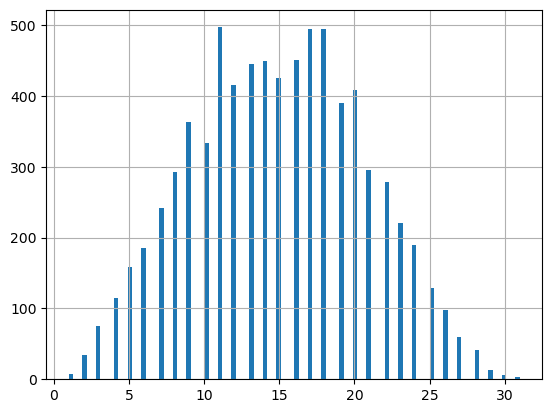

In [165]:
# count the number of words and plot a histogram
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df['word_count'].hist(bins=100)


In [166]:
# label encoding of keyword using sklearn
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['keyword'] = le.fit_transform(df['keyword'].fillna(''))
df['keyword'].sample(5)

6316    184
2908     84
2950     85
6406    187
1796     52
Name: keyword, dtype: int64

In [167]:
df['keyword'].nunique()

222

In [168]:
df.target.unique()

array([1, 0])

In [169]:
df.sample(20)

,id,keyword,location,text,target,word_count
207,293,5,Playa,http://t.co/J8TYT1XRRK Twelve feared killed in...,1,11
7038,10084,206,NaN,Obama Declares Disaster for Typhoon-Devastated...,1,15
814,1182,24,Guelph Ontario Canada,New print available on http://t.co/ucy5fEA9yu!...,0,14
5907,8435,172,USA,Watch This Airport Get Swallowed Up By A Sands...,1,14
4491,6387,130,Miami Beach,everyone's wonder who will win and I'm over he...,0,16
5872,8389,171,CA ??DC,there are a few people I'd let ruin my life my...,0,23
1925,2768,56,NaN,@emaaalay thank you. ?? now I don't have a cit...,0,13
635,919,18,NaN,@cspanwj If 90BLKs&amp;8WHTs colluded 2 take W...,1,22
6839,9796,200,"Greensburg, PA",Did you know @lilithsaintcrow had a new releas...,0,20
2440,3504,71,"Chicago, IL",Service on the Green Line has resumed after an...,1,16


In [170]:
import spacy
nlp = spacy.load('en_core_web_sm')
PAD_IDX=1
SOS_IDX=2
UNK_IDX=0


# Tokenizer-Funktion
def tokenizer(text):
    # use spacey for tokenization
    return [tok.text for tok in nlp.tokenizer(text)]

# Vokabular erstellen
def build_vocab(texts, vocab_size=None):
    word_to_idx = {}
    for text in texts:
        tokens = tokenizer(text)
        for token in tokens:
            if token not in word_to_idx:
                word_to_idx[token] = len(word_to_idx)
    if vocab_size is not None:
        word_to_idx = {k: v for k, v in sorted(word_to_idx.items(), key=lambda item: item[1])[:vocab_size-3]}
    # increase all idx by 3  
    word_to_idx = {k: v+3 for k, v in word_to_idx.items()}
    # add special tokens
    word_to_idx['<unk>'] = UNK_IDX
    word_to_idx['<pad>'] = PAD_IDX
    word_to_idx['<sos>'] = SOS_IDX
    return word_to_idx

# Texte in Sequenzen von Wortindizes umwandeln
def text_to_indices(text, word_to_idx):
    tokens = tokenizer(text)
    indices = [word_to_idx[token] if token in word_to_idx else 0 for token in tokens]
    return indices

num_epochs = 2

# Aufteilung in Trainings- und Testdaten
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Erstellung des Vokabulars
texts = train_df['text'].tolist()
word_to_idx = build_vocab(texts, vocab_size=10000)

idx_to_word = {v: k for k, v in word_to_idx.items()}

vocab_size=len(word_to_idx)
print("vocab size:", vocab_size)

vocab size: 10000


In [171]:
def text_pipeline(x):                           
    return text_to_indices(x, word_to_idx)

text_pipeline("This is a test sentence")

[1639, 101, 27, 9219, 0]

In [172]:
class DisasterTweetsDataset(Dataset):
    def __init__(self, df, vocab_size=10000, test=False, sequence_length=100):
        self.df = df
        self.vocab_size = vocab_size
        self.test = test
        self.sequence_length = sequence_length
        self.empty_dummy_for_fixed_length = torch.ones(self.sequence_length, dtype=torch.long)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        x= self.df.iloc[idx]["text"]
        x = text_pipeline(x)
        x = torch.tensor(x)
        x= torch.cat((x, self.empty_dummy_for_fixed_length))[:self.sequence_length]
        return x
    
disaster_tweets_dataset = DisasterTweetsDataset(df, vocab_size=vocab_size)
x=disaster_tweets_dataset[0]
print(x)


tensor([  74,    0,  869,   47, 7909,    7,  113,   16, 2907, 2093,    0,    0,
         230,  346,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1])


In [173]:

def check_transformer_input_dimensions(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, memory_key_padding_mask):
    batch_size = src.size(1)
    src_seq_len = src.size(0)
    tgt_seq_len = tgt_input.size(0)

    assert src.dim() == 2, f"src should have 2 dimensions, but has {src.dim()}"
    assert src.size(1) == batch_size, f"The second dimension of src should be batch_size, but is {src.size(1)}"

    # assert no nan values
    assert torch.isnan(src).sum() == 0, f"src contains {torch.isnan(src).sum()} nan values"
    assert torch.isnan(tgt_input).sum() == 0, f"tgt_input contains {torch.isnan(tgt_input).sum()} nan values"
    assert torch.isnan(src_mask).sum() == 0, f"src_mask contains {torch.isnan(src_mask).sum()} nan values"
    assert torch.isnan(tgt_mask).sum() == 0, f"tgt_mask contains {torch.isnan(tgt_mask).sum()} nan values"
    assert torch.isnan(src_padding_mask).sum() == 0, f"src_padding_mask contains {torch.isnan(src_padding_mask).sum()} nan values"
    assert torch.isnan(tgt_padding_mask).sum() == 0, f"tgt_padding_mask contains {torch.isnan(tgt_padding_mask).sum()} nan values"
    assert torch.isnan(memory_key_padding_mask).sum() == 0, f"memory_key_padding_mask contains {torch.isnan(memory_key_padding_mask).sum()} nan values"
        
    assert tgt_input.dim() == 2, f"tgt_input should have 2 dimensions, but has {tgt_input.dim()}"
    assert tgt_input.size(1) == batch_size, f"The second dimension of tgt_input should be batch_size, but is {tgt_input.size(1)}"
    
    assert src_mask.dim() == 2, f"src_mask should have 2 dimensions, but has {src_mask.dim()}"
    assert src_mask.size() == (src_seq_len, src_seq_len), f"src_mask should have shape (src_seq_len, src_seq_len), but has {src_mask.size()}"
    
    assert tgt_mask.dim() == 2, f"tgt_mask should have 2 dimensions, but has {tgt_mask.dim()}"
    assert tgt_mask.size() == (tgt_seq_len, tgt_seq_len), f"tgt_mask should have shape (tgt_seq_len, tgt_seq_len), but has {tgt_mask.size()}"
    
    for mask, name in zip([src_padding_mask, memory_key_padding_mask], ["src_padding_mask", "memory_key_padding_mask"]):
        assert mask.dim() == 2, f"{name} should have 2 dimensions, but has {mask.dim()}"
        assert mask.size() == (batch_size, src_seq_len), f"{name} should have shape (batch_size, src_seq_len), but has {mask.size()}"
    
    assert tgt_padding_mask.dim() == 2, f"tgt_padding_mask should have 2 dimensions, but has {tgt_padding_mask.dim()}"
    assert tgt_padding_mask.size() == (batch_size, tgt_seq_len), f"tgt_padding_mask should have shape (batch_size, tgt_seq_len), but has {tgt_padding_mask.size()}"



In [181]:
from torch import nn
import torch.nn.init as init

import torch
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, emb_size, nhead, num_layers, dim_feedforward, dropout):
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.pos_encoder = PositionalEncoding(emb_size, dropout)
        encoder_layers = nn.TransformerEncoderLayer(emb_size, nhead, dim_feedforward, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.emb_size = emb_size

    def forward(self, src, src_mask, src_padding_mask):
        src_emb = self.embedding(src) * math.sqrt(self.emb_size)
        print("nan count in embedding: ", torch.isnan(src_emb).sum().item())
        src_emb = self.pos_encoder(src_emb)
        print(f"Max value in pos encoding: {src_emb.max().item()}, Min value pos encoding: {src_emb.min().item()}")
        print(f"stddev value pos encoding: {src_emb.std().item()}, mean value pos encoding: {src_emb.mean().item()}")
        print("nan count in pos encoder: ", torch.isnan(src_emb).sum().item())
        print("nan count in src: ", torch.isnan(src).sum().item())
        print("nan count in src_mask: ", torch.isnan(src_mask).sum().item())
        print("nan count in src_padding_mask: ", torch.isnan(src_padding_mask).sum().item())
        output = self.transformer_encoder(src_emb, mask=src_mask, src_key_padding_mask=src_padding_mask)
        print("nan count in encoder: ", torch.isnan(output).sum().item())
        return output

class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, emb_size, nhead, num_layers, dim_feedforward, dropout):
        super(TransformerDecoder, self).__init__()
        self.emb_size = emb_size
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.pos_encoder = PositionalEncoding(emb_size, dropout)
        decoder_layers = nn.TransformerDecoderLayer(emb_size, nhead, dim_feedforward, dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layers, num_layers)

    def forward(self, tgt, memory, tgt_mask, tgt_padding_mask, memory_key_padding_mask):
        tgt_emb = self.embedding(tgt) * math.sqrt(self.emb_size)
        tgt_emb = self.pos_encoder(tgt_emb)
        output = self.transformer_decoder(tgt_emb, memory, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_padding_mask, memory_key_padding_mask=memory_key_padding_mask)
        print("nan count in decoder: ", torch.isnan(output).sum().item())
        return output


class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, vocab_size=None):
        super(Seq2SeqTransformer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.fc = nn.Linear(decoder.emb_size, vocab_size)
        self.apply(self.init_weights)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        if isinstance(m, nn.Embedding):
            nn.init.uniform_(m.weight, -0.05, 0.05)


    def forward(self, 
                src=None,
                tgt=None, 
                src_mask=None, 
                tgt_mask=None, 
                src_padding_mask=None, 
                tgt_padding_mask=None, 
                memory_key_padding_mask=None):
        memory = self.encoder(src, src_mask, src_padding_mask)
        outs = self.decoder(tgt, memory, tgt_mask, tgt_padding_mask, memory_key_padding_mask)
        outs= self.fc(outs)
        return outs

def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=device).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

import torch

def shift_right(target_sequences):
    batch_size, seq_len = target_sequences.size()
    sos_tensor = torch.full((batch_size, 1), SOS_IDX, dtype=target_sequences.dtype, device=target_sequences.device)    
    shifted_sequences = torch.cat([sos_tensor, target_sequences[:, :-1]], dim=1)
    return shifted_sequences

# test all together
df_to_test=df.sample(10)
dataset_to_test = DisasterTweetsDataset(df_to_test, vocab_size=vocab_size)
dataloader_to_test = DataLoader(dataset_to_test, batch_size=4, shuffle=True)
model = Seq2SeqTransformer(
    encoder=TransformerEncoder(vocab_size=vocab_size, emb_size=512, nhead=8, num_layers=6, dim_feedforward=2048, dropout=0.1),
    decoder=TransformerDecoder(vocab_size=vocab_size, emb_size=512, nhead=8, num_layers=6, dim_feedforward=2048, dropout=0.1),
    vocab_size=vocab_size
)

model.to(device)

def get_text_from_model_output(output, idx_to_word):
    output = output.argmax(dim=2)
    output_text=[]
    for i in range(output.size(0)):
        for word_idx in output[i]:
            output_token=""
            if word_idx.item() == PAD_IDX:
                break
            elif word_idx.item() == 0:
                output_token="<unk>"
            else:
                output_token=idx_to_word[word_idx.item()]
            output_text.append(output_token)
    return " ".join(output_text[:30])


# Beispielaufruf der Funktion

    
for x in dataloader_to_test:  
    src = x.to(device)
    tgt = x.to(device)

    # shift targets to the right by one and add padding token at the end
    tgt_input = shift_right(tgt)

    src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
    
    
    check_transformer_input_dimensions(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)

    
    output = model(src=src, 
                   tgt=tgt_input, 
                   src_mask=src_mask, 
                   tgt_mask=tgt_mask, 
                   src_padding_mask=src_padding_mask, 
                   tgt_padding_mask=tgt_padding_mask,
                   memory_key_padding_mask=src_padding_mask)

    print("x.shape", x.shape)
    print("model output shape: " , output.shape)
    print("nan count in output: ", torch.isnan(output).sum().item())
    
    # map output to vocab for each batch
    
    # output is batch_size, sequence_length, vocab_size
    # apply idx_to_word for each batch
    output_text = get_text_from_model_output(output, idx_to_word)
    print("model output: " , output_text)
    # Modify the line where the input tensor is created
   


nan count in embedding:  0
Max value in pos encoding: 2.3678228855133057, Min value pos encoding: -2.32763934135437
stddev value pos encoding: 0.8757405281066895, mean value pos encoding: 0.5315021276473999
nan count in pos encoder:  0
nan count in src:  0
nan count in src_mask:  0
nan count in src_padding_mask:  0
nan count in encoder:  147456
nan count in decoder:  169984
x.shape torch.Size([4, 100])
model output shape:  torch.Size([4, 100, 10000])
nan count in output:  3320000
model output:  http://t.co/UUWEiKD7sP Boone Sicily series http://t.co/V1mtR517Ue soul http://t.co/V1mtR517Ue Dudes http://t.co/eL24mnFcHw Bamenda Fatalities El PRESENT Estate seismic insane series <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
nan count in embedding:  0
Max value in pos encoding: 2.3679797649383545, Min value pos encoding: -2.2466166019439697
stddev value pos encoding: 0.8779615163803101, mean value pos encoding: 0.5326945185661316
nan count in pos encoder:  0
na

/opt/homebrew/Caskroom/miniconda/base/envs/torch_ds/lib/python3.10/site-packages/torch/nn/functional.py:5038: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


nan count in encoder:  157696
nan count in decoder:  196608
x.shape torch.Size([4, 100])
model output shape:  torch.Size([4, 100, 10000])
nan count in output:  3840000
model output:  options Luiz sorry collapse <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
nan count in embedding:  0
Max value in pos encoding: 2.3678839206695557, Min value pos encoding: -1.2557591199874878
stddev value pos encoding: 0.885172963142395, mean value pos encoding: 0.5270705223083496
nan count in pos encoder:  0
nan count in src:  0
nan count in src_mask:  0
nan count in src_padding_mask:  0
nan count in encoder:  82944
nan count in decoder:  82944
x.shape torch.Size([2, 100])
model output shape:  torch.Size([2, 100, 10000])
nan count in output:  1620000
model output:  Jen flawless helps paths Birmingham Green manåÊarmed @roughdeal1 bagged Luiz record http://t.co/V1mtR517Ue Noel KPdied casualties Engl

In [175]:
class Learner():
    
    def __init__(self, model, train_dataloader, valid_dataloader, optimizer, scheduler, loss_func, device):
        self.model=model
        self.device=device
        self.model=self.model.to(self.device)
        self.train_dataloader=train_dataloader
        self.valid_dataloader=valid_dataloader
        self.optimizer=optimizer
        self.scheduler=scheduler
        self.loss_func=loss_func
        self.accu_train=[]
        self.accu_valid=[]

    def evaluate(self, loader):
        self.model.eval()  # Set model to evaluation mode
        total_loss = 0
        total_items = 0

        with torch.no_grad():  # No gradients needed for evaluation
            for x in loader:
                src = x.to(self.device)
                tgt = x.to(self.device)
                tgt_input = tgt#[:-1, :]

                src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
                output = self.model(src=src, 
                                    tgt=tgt_input, 
                                    src_mask=src_mask, 
                                    tgt_mask=tgt_mask, 
                                    src_padding_mask=src_padding_mask, 
                                    tgt_padding_mask=tgt_padding_mask,
                                    memory_key_padding_mask=src_padding_mask)
                
                # You may need to adjust the shape of y and output depending on your loss function
                print(y.shape)
                loss = self.loss_func(output, y)
                total_loss += loss.item()
                total_items += 1

        average_loss = total_loss / total_items
        return average_loss


    def fit_one_epoch(self):
        epoch_start_time = time.time()
        self.model.train()
        losses=[]

        for idx, x in enumerate(self.train_dataloader):
            self.optimizer.zero_grad()
            src = x.to(device)
            tgt = x.to(device)

            # shift targets to the right
            tgt_input = shift_right(tgt)
    
            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
    
            check_transformer_input_dimensions(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
            
            
            output = model(src=src, 
                   tgt=tgt_input, 
                   src_mask=src_mask, 
                   tgt_mask=tgt_mask, 
                   src_padding_mask=src_padding_mask, 
                   tgt_padding_mask=tgt_padding_mask,
                   memory_key_padding_mask=src_padding_mask)
            output = output.permute(0, 2, 1) # permute to have batch_size, vocab_size, sequence_length
            #print("output of batch", output)
            # count nan values in output
            print("nan values in output", torch.isnan(output).sum())
            loss = self.loss_func(output, tgt_input)
            print("loss of batch", loss)
            loss.backward()
            self.optimizer.step()
            losses.append(loss.item())

        #accu_train = self.evaluate(self.train_dataloader)
        #accu_valid = self.evaluate(self.valid_dataloader)
        #self.accu_train.append(accu_train)
        #self.accu_valid.append(accu_valid)
        #self.scheduler.step() 
        return sum(losses)/len(losses)

    def fit_epochs(self, number=None):
        for epoch in range(number):
            loss=self.fit_one_epoch()
            print('-' * 59)
            print('| end of epoch {:3d} | loss: {:5.2f}s '.format(
                                        epoch,
                                        loss))
                                           

    def plot_training(self):
        plt.plot(self.accu_train, label="train accuracy")
        plt.plot(self.accu_valid, label="valid accuracy")
        plt.legend()
        plt.show()

In [176]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

if kaggle==False:
    device = torch.device("cpu")



# Hyperparameters
LR = 0.001  # learning rate
BATCH_SIZE = 128 # batch size for training


model = Seq2SeqTransformer(
    encoder=TransformerEncoder(vocab_size=vocab_size, emb_size=128, nhead=2, num_layers=2, dim_feedforward=512, dropout=0.1),
    decoder=TransformerDecoder(vocab_size=vocab_size, emb_size=128, nhead=2, num_layers=2, dim_feedforward=512, dropout=0.1),
    vocab_size=vocab_size
)

train_dataset=DisasterTweetsDataset(train_df, vocab_size=vocab_size)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True)
valid_dataset=DisasterTweetsDataset(test_df, vocab_size=vocab_size)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

loss_func = torch.nn.CrossEntropyLoss()
#
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10.0, gamma=0.9)   # every 3 epochs, LR is multiplied by 0.7

learner=Learner(model, train_dataloader, valid_dataloader, optimizer, scheduler, loss_func, device)

In [177]:

learner.fit_epochs(10)


nan count in embedding:  0
nan count in pos encoder:  0
nan count in src:  0
nan count in src_mask:  0
nan count in src_padding_mask:  0
nan count in encoder:  1081344
nan count in decoder:  1212416
nan values in output tensor(94720000)
loss of batch tensor(nan, grad_fn=<NllLoss2DBackward0>)
nan count in embedding:  1445248
nan count in pos encoder:  1445248
nan count in src:  0
nan count in src_mask:  0
nan count in src_padding_mask:  0
nan count in encoder:  1638400
nan count in decoder:  1638400
nan values in output tensor(128000000)
loss of batch tensor(nan, grad_fn=<NllLoss2DBackward0>)
nan count in embedding:  1549184
nan count in pos encoder:  1549184
nan count in src:  0
nan count in src_mask:  0
nan count in src_padding_mask:  0
nan count in encoder:  1638400
nan count in decoder:  1638400
nan values in output tensor(128000000)
loss of batch tensor(nan, grad_fn=<NllLoss2DBackward0>)
nan count in embedding:  1559680
nan count in pos encoder:  1559680
nan count in src:  0
nan co

KeyboardInterrupt: 

In [ ]:
learner.fit_epochs(10)


-----------------------------------------------------------
| end of epoch   0 | loss:   nans 
-----------------------------------------------------------
| end of epoch   1 | loss:   nans 
-----------------------------------------------------------
| end of epoch   2 | loss:   nans 
-----------------------------------------------------------
| end of epoch   3 | loss:   nans 
-----------------------------------------------------------
| end of epoch   4 | loss:   nans 
-----------------------------------------------------------
| end of epoch   5 | loss:   nans 
-----------------------------------------------------------
| end of epoch   6 | loss:   nans 
-----------------------------------------------------------
| end of epoch   7 | loss:   nans 
-----------------------------------------------------------
| end of epoch   8 | loss:   nans 
-----------------------------------------------------------
| end of epoch   9 | loss:   nans 


In [ ]:
learner.fit_epochs(10)


-----------------------------------------------------------
| end of epoch   0 | loss:   nans 
-----------------------------------------------------------
| end of epoch   1 | loss:   nans 
-----------------------------------------------------------
| end of epoch   2 | loss:   nans 


KeyboardInterrupt: 

In [ ]:
local_test_path='test.csv'
kaggle_test_path='/kaggle/input/nlp-getting-started/test.csv'

df_submission_test_data=pd.read_csv(kaggle_test_path if kaggle else local_test_path)
df_submission_test_data.sample(5)

,id,keyword,location,text
2191,7336,nuclear%20reactor,Helsinki,Finnish Nuclear Plant to Move Ahead After Fina...
3102,10267,war%20zone,MDS af ?,Saipan looks like a war zone though
2008,6761,lightning,NaN,Baby you're like lightning in a bottle
2111,7079,meltdown,"St. Catherine, Jamaica, W.I.",CommoditiesåÊAre Crashing Like It's 2008 All O...
622,2029,casualties,Ngayogyakarta Hadiningrat,Memorial day of 70 years Hiroshima and Nagasak...


In [ ]:
# label encode keyword using trained label encoder
df_submission_test_data['keyword'] = le.transform(df_submission_test_data['keyword'].fillna(''))

In [ ]:
def collate_batch_test_data(batch):
    x, keywords = zip(*batch)
    # collate for embedding bag
    empty_dummy_for_fixed_length = torch.zeros(sequence_length, dtype=torch.long)
    x = torch.stack([torch.cat((text, empty_dummy_for_fixed_length))[:sequence_length] for text in x])
    keywords=torch.stack(keywords)
    return x, keywords

In [ ]:
model.eval()
preds=[]
test_dataset=DisasterTweetsDataset(df_submission_test_data, vocab_size=vocab_size, test=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch_test_data)
with torch.no_grad():
    for idx, (x, keywords) in enumerate(test_dataloader):
        predicted_label = model(x, keywords)
        preds.extend(predicted_label.argmax(1).tolist())

df_submission_test_data["target"]=preds
df_submission_test_data[["id", "target"]].to_csv("submission_04.csv", index=False)

In [ ]:
# Score: 0.75237